In [1]:
from noise import generate_noise_realization
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datageneration.datageneration.waveforms import *
from datageneration.datageneration.distributions import *
from datageneration.datageneration.population_model import *

# Generate realistic LISA noise

In [142]:
noise_dict = generate_noise_realization(5, # dt (in s)
                                        30*24*3600 # Tobs (in s)
                                       )

/Users/rjrosati/opt/anaconda3/envs/lisa-eps/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/rjrosati/opt/anaconda3/envs/lisa-eps/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/rjrosati/opt/anaconda3/envs/lisa-eps/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/rjrosati/opt/anaconda3/envs/lisa-eps/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/rjrosati/opt/anaconda3/envs/lisa-eps/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Som

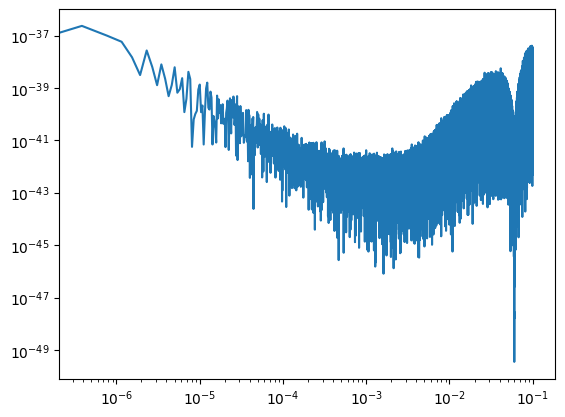

In [3]:
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0])

In [141]:
# note that noise timeseries for A,E,T channels is here:
noise_dict["timeseries"]

array([[ 1.67380212e-20, -5.99081627e-21,  4.85218544e-21, ...,
        -7.05145786e-21,  5.50236930e-21, -1.27949886e-20],
       [-1.81673119e-20,  1.04590016e-20, -5.19247885e-21, ...,
         1.36500615e-20, -1.28859505e-20,  2.03355343e-20],
       [-1.08565528e-21,  1.44205041e-24, -1.88338918e-21, ...,
        -5.83055948e-21, -1.95174550e-21,  9.29648100e-21]])

# Generate the population

In [129]:
limits = {'chirp_mass':          [0.5, 1.0],  # In solar masses
          'seperation':          [0.5, 10.0],   # In 1e8 meters
          'luminosity_distance': [1.0, 50.0],     # In kilo parsecs
          'phase':               [0, 2*np.pi]}
## Instantiate the population distribution object

dist = PowerLawChirpPowerLawSeperation(limits=limits, 
                                       distance_power_law_index=1,   # p(d) ~ d
                                       poisson=True) 			     # Total Number of sources should be drawn from poisson distribution

Lambda = {'alpha' : 4.0, 'beta' : -2.0}
popdict = dist.waveform.compute_waveform_parameters(dist.generate_samples(Lambda, size=1000))
df = pd.DataFrame(popdict)

In [130]:
poptimes, popstrains = dist.waveform.generate_waveforms(popdict)

In [131]:
dt = poptimes[1] - poptimes[0]

In [132]:
from utils import get_rfft
# possible bug here in frequencies when vectorized
popfreq, popstrainsfft = get_rfft(popstrains.T, poptimes, 1/dt)
popfreq = np.fft.rfftfreq(len(poptimes),dt)

In [ ]:
# noise timeseries is calibrated so that scipy.signal.welch gives correct amplitude

In [139]:
fw, popwelch = scipy.signal.welch(np.sum(popstrains.T,axis=0),fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)

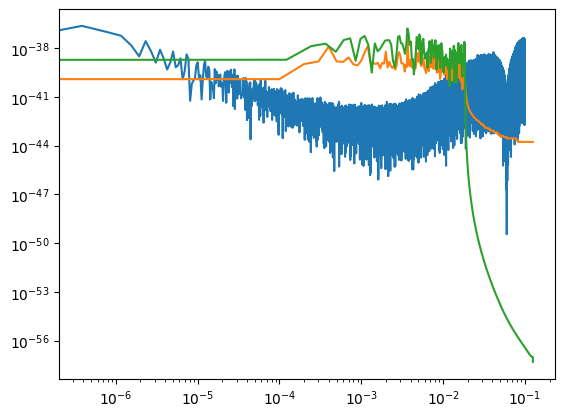

In [140]:
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0])
plt.loglog(popfreq,np.sum(np.abs(popstrainsfft)**2/poptimes[-1]*dt,axis=0))
plt.loglog(fw,popwelch)

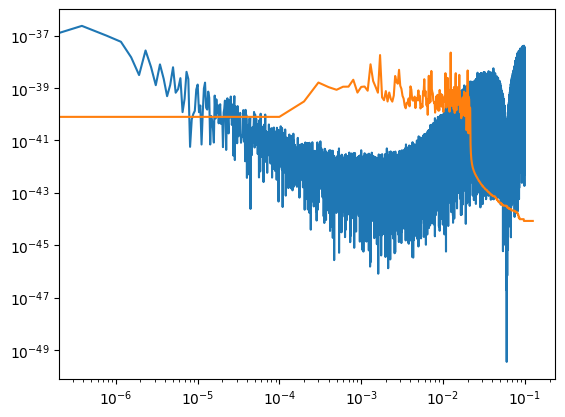

In [128]:
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0])
plt.loglog(popfreq,np.sum(np.abs(popstrainsfft)**2/poptimes[-1],axis=0))

# Iterative subtraction method

In [ ]:
# need to implement this, basically:
# add noise timeseries + WDs
# compute welched PSD, subtract WDs that exceed SNR (to current noise+signals PSD of your threshold (typically 7))
# repeat above step at least 15-ish times

# New method -- does it give the same answer?

In [ ]:
# see notes / code in foreground.py
# try it with same population and make sure the answer is identical / equivalent to iterative subtraction